In [1]:
pip install pytorch-msssim

Note: you may need to restart the kernel to use updated packages.


In [2]:
import os
import time
import torch
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.utils as vutils
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import numpy as np
from pytorch_msssim import ssim

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# Training classifier params
CLS_EPOCHS = 50
CLS_BATCH = 128
CLS_LR = 0.1

# Generator / inversion params
GEN_EPOCHS = 100
GEN_BATCH = 64
latent_dim = 100
cond_dim = 10
F_ch = 64                 # channels at 10x10 stage
alpha, beta, gamma, delta = 100.0, 100.0, 1000.0, 1000.0

# Other
NUM_CLASSES = 10
SAMPLES_PER_CLASS = 20    # for evaluation
SAVE_MODEL_PATH = "resnet_mnist.pth"
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)

Device: cuda


In [4]:
transform = transforms.Compose([
    transforms.Resize(32),     # Resize MNIST to 32x32 so generator architecture can remain same
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

trainset = torchvision.datasets.MNIST(root='./data', train=True,
                                      download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=128,
                                          shuffle=True)

testset = torchvision.datasets.MNIST(root='./data', train=False,
                                     download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=100,
                                         shuffle=False)


In [5]:
class ResNetMNIST(nn.Module):
    def __init__(self, num_classes=10, pretrained=True):
        super().__init__()

        self.resnet = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1 if pretrained else None)
        
        self.resnet.conv1 = nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.resnet.maxpool = nn.Identity()  # remove downsampling

        in_features = self.resnet.fc.in_features
        self.resnet.fc = nn.Linear(in_features, num_classes)

    def forward(self, x, return_features=False):
        # Replicate torchvision forward manually to access penultimate features
        x = self.resnet.conv1(x)
        x = self.resnet.bn1(x)
        x = self.resnet.relu(x)
        x = self.resnet.layer1(x)
        x = self.resnet.layer2(x)
        x = self.resnet.layer3(x)
        x = self.resnet.layer4(x)
        x = self.resnet.avgpool(x)
        feat = torch.flatten(x, 1)
        logits = self.resnet.fc(feat)

        if return_features:
            return logits, feat
        return logits


# Instantiate
classifier = ResNetMNIST(num_classes=NUM_CLASSES).to(device)

In [6]:
criterion = nn.CrossEntropyLoss()
optimizer_cls = optim.SGD(classifier.parameters(), lr=CLS_LR, momentum=0.9, weight_decay=5e-4)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer_cls, milestones=[60, 120, 160], gamma=0.2)

def train_classifier_one_epoch(epoch):
    classifier.train()
    running_loss, correct, total = 0.0, 0, 0
    start = time.time()
    for inputs, targets in trainloader:
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer_cls.zero_grad()
        outputs = classifier(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer_cls.step()
        running_loss += loss.item() * targets.size(0)
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()
    train_loss = running_loss / total
    train_acc = 100. * correct / total
    print(f"[CLS] Epoch {epoch} Train Loss: {train_loss:.4f} Acc: {train_acc:.2f}% Time: {time.time()-start:.1f}s")
    return train_loss, train_acc

def test_classifier(epoch):
    classifier.eval()
    running_loss, correct, total = 0.0, 0, 0
    with torch.no_grad():
        for inputs, targets in testloader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = classifier(inputs)
            loss = criterion(outputs, targets)
            running_loss += loss.item() * targets.size(0)
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
    test_loss = running_loss / total
    acc = 100. * correct / total
    print(f"[CLS] Epoch {epoch} Test Loss: {test_loss:.4f} Acc: {acc:.2f}%")
    return test_loss, acc

Training classifier from scratch...
[CLS] Epoch 1 Train Loss: 0.1312 Acc: 96.80% Time: 59.0s
[CLS] Epoch 1 Test Loss: 0.0303 Acc: 99.12%
[CLS] Saved best model (acc=99.12%)
[CLS] Epoch 2 Train Loss: 0.0309 Acc: 99.05% Time: 60.6s
[CLS] Epoch 2 Test Loss: 0.0371 Acc: 98.85%
[CLS] Epoch 3 Train Loss: 0.0274 Acc: 99.17% Time: 63.1s
[CLS] Epoch 3 Test Loss: 0.0554 Acc: 98.49%
[CLS] Epoch 4 Train Loss: 0.0285 Acc: 99.14% Time: 62.6s
[CLS] Epoch 4 Test Loss: 0.0486 Acc: 98.73%
[CLS] Epoch 5 Train Loss: 0.0272 Acc: 99.16% Time: 62.5s
[CLS] Epoch 5 Test Loss: 0.0315 Acc: 99.07%
[CLS] Epoch 6 Train Loss: 0.0267 Acc: 99.18% Time: 62.5s
[CLS] Epoch 6 Test Loss: 0.0483 Acc: 98.60%
[CLS] Epoch 7 Train Loss: 0.0275 Acc: 99.19% Time: 62.6s
[CLS] Epoch 7 Test Loss: 0.0404 Acc: 98.86%
[CLS] Epoch 8 Train Loss: 0.0276 Acc: 99.17% Time: 62.6s
[CLS] Epoch 8 Test Loss: 0.0393 Acc: 98.83%
[CLS] Epoch 9 Train Loss: 0.0245 Acc: 99.30% Time: 62.7s
[CLS] Epoch 9 Test Loss: 0.0314 Acc: 99.10%
[CLS] Epoch 10 Trai

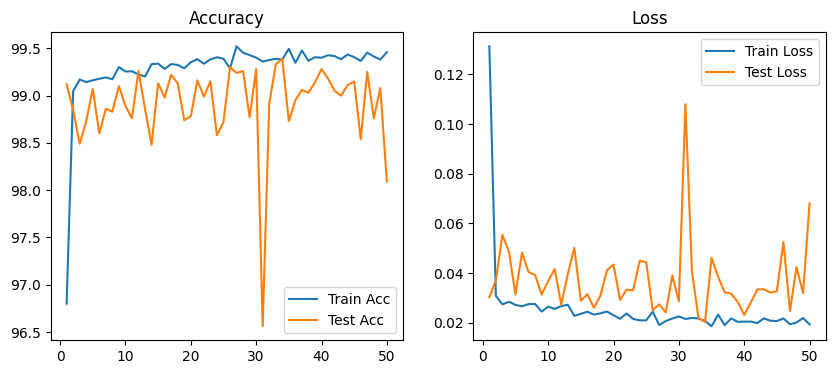

ResNetMNIST(
  (resnet): ResNet(
    (conv1): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): Identity()
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (

In [7]:
def train_classifier(epochs=CLS_EPOCHS):
    best_acc = 0.0
    train_losses, train_accs = [], []
    test_losses, test_accs = [], []
    for ep in range(1, epochs+1):
        tr_loss, tr_acc = train_classifier_one_epoch(ep)
        te_loss, te_acc = test_classifier(ep)
        scheduler.step()
        train_losses.append(tr_loss); train_accs.append(tr_acc)
        test_losses.append(te_loss); test_accs.append(te_acc)
        if te_acc > best_acc:
            best_acc = te_acc
            torch.save(classifier.state_dict(), SAVE_MODEL_PATH)
            print(f"[CLS] Saved best model (acc={best_acc:.2f}%)")
    # plot training curves
    plt.figure(figsize=(10,4))
    plt.subplot(1,2,1)
    plt.plot(range(1,len(train_accs)+1), train_accs, label='Train Acc')
    plt.plot(range(1,len(test_accs)+1), test_accs, label='Test Acc')
    plt.title("Accuracy")
    plt.legend()
    plt.subplot(1,2,2)
    plt.plot(range(1,len(train_losses)+1), train_losses, label='Train Loss')
    plt.plot(range(1,len(test_losses)+1), test_losses, label='Test Loss')
    plt.title("Loss")
    plt.legend()
    plt.show()

# Only train classifier if model file not present
if not os.path.isfile(SAVE_MODEL_PATH):
    print("Training classifier from scratch...")
    train_classifier(epochs=CLS_EPOCHS)
else:
    print("Found saved classifier. Loading...")
    classifier.load_state_dict(torch.load(SAVE_MODEL_PATH, map_location=device))

# Freeze classifier (but allow autograd to flow into generator through the classifier's ops)
for p in classifier.parameters():
    p.requires_grad = False
classifier.eval()

In [8]:
# We will pass the **softmaxed** conditioning vector INTO the generator (so it's a distribution).
def sample_vector_condition(batch, num_classes, device):
    v = torch.randn(batch, num_classes, device=device)
    P = F.softmax(v, dim=1)      # conditioning distribution P (batch, num_classes)
    labels = P.argmax(dim=1)     # integer labels used in CE target
    return P, P, labels         # return vector_cond (P), P_target, labels

# Precompute 'hot' matrices for all classes and reuse
_precomputed_hot = torch.zeros(NUM_CLASSES, 1, NUM_CLASSES, NUM_CLASSES, device=device)
for k in range(NUM_CLASSES):
    mat = torch.zeros(NUM_CLASSES, NUM_CLASSES, device=device)
    mat[k, :] = 1.0
    mat[:, k] = 1.0
    _precomputed_hot[k, 0] = mat

def build_hot_matrix(labels, N=NUM_CLASSES, device=device):
    # labels: (batch,) ints on device
    # returns (batch,1,10,10) by creating appropriate matrices
    batch_size = labels.size(0)
    hot_mats = torch.zeros(batch_size, 1, 10, 10, device=device)

    for i, label in enumerate(labels):
        # Create a 10x10 matrix with the label information
        # You can experiment with different patterns here
        mat = torch.zeros(10, 10, device=device)

        # Simple pattern: set rows and columns corresponding to label
        mat[label, :] = 1.0
        mat[:, label] = 1.0

        hot_mats[i, 0] = mat

    return hot_mats

In [9]:
# Fix the generator architecture first
class Generator(nn.Module):
    def __init__(self, latent_dim=latent_dim, cond_dim=cond_dim, F=F_ch, out_ch=1):
        super().__init__()
        self.latent_dim = latent_dim
        self.cond_dim = cond_dim

        # Initial projection to 4x4
        self.convT1 = nn.ConvTranspose2d(latent_dim + cond_dim, F * 8, kernel_size=4, stride=1, padding=0)  # 1x1 -> 4x4
        self.bn1 = nn.BatchNorm2d(F * 8)

        # 4x4 -> 8x8
        self.convT2 = nn.ConvTranspose2d(F * 8 + 1, F * 4, kernel_size=4, stride=2, padding=1)  # +1 for hot channel
        self.bn2 = nn.BatchNorm2d(F * 4)

        # 8x8 -> 16x16
        self.convT3 = nn.ConvTranspose2d(F * 4, F * 2, kernel_size=4, stride=2, padding=1)
        self.bn3 = nn.BatchNorm2d(F * 2)

        # 16x16 -> 32x32
        self.convT4 = nn.ConvTranspose2d(F * 2, F, kernel_size=4, stride=2, padding=1)
        self.bn4 = nn.BatchNorm2d(F)

        # Final convolution to get 1 channels
        self.final_conv = nn.Conv2d(F, out_ch, kernel_size=3, stride=1, padding=1)
        self.dropout = nn.Dropout2d(0.2)  # Reduced dropout

    def forward(self, z, vec_cond, hot_mat):
        # z: (B, latent), vec_cond: (B, cond_dim), hot_mat: (B,1,10,10)
        x = torch.cat([z, vec_cond], dim=1)           # (B, latent+cond)
        x = x.view(x.size(0), x.size(1), 1, 1)        # (B, latent+cond,1,1)

        # 1x1 -> 4x4
        x = F.leaky_relu(self.bn1(self.convT1(x)), 0.2)

        # Resize hot_mat to match current feature size (4x4)
        hot_resized = F.interpolate(hot_mat, size=(4, 4), mode='bilinear', align_corners=False)
        x = torch.cat([x, hot_resized], dim=1)

        # 4x4 -> 8x8
        x = F.leaky_relu(self.bn2(self.convT2(x)), 0.2)
        x = self.dropout(x)

        # 8x8 -> 16x16
        x = F.leaky_relu(self.bn3(self.convT3(x)), 0.2)

        # 16x16 -> 32x32
        x = F.leaky_relu(self.bn4(self.convT4(x)), 0.2)

        img = torch.tanh(self.final_conv(x))  # range [-1,1]
        return img

In [10]:
def kl_divergence_targetP(logits, P_target):
    # D_KL(P_target || Q_pred)
    # logits: (B,C); P_target: (B,C)
    log_softmax = F.log_softmax(logits, dim=1)
    kl_div = F.kl_div(log_softmax, P_target, reduction='batchmean', log_target=False)
    return kl_div

def cosine_similarity_loss(features):
    # features: (B, D)
    eps = 1e-8
    f = features / (features.norm(dim=1, keepdim=True) + eps)  # normalize
    sim = f @ f.T  # (B,B)
    B = features.size(0)
    off_diag_sum = sim.sum() - B  # subtract diagonal ones
    denom = B * (B - 1)
    return off_diag_sum / (denom + 1e-12)

def orthogonality_loss(features):
    # make normalized features orthogonal (Gram approx I)
    eps = 1e-8
    f = features / (features.norm(dim=1, keepdim=True) + eps)
    G = f @ f.T
    B = features.size(0)
    I = torch.eye(B, device=features.device)
    return ((G - I)**2).mean()
def ssim_loss(imgs, ref_imgs):
    """
    Structural Similarity (SSIM) loss between generated and reference images.
    Both tensors in range [-1, 1].
    Returns (1 - SSIM) averaged over the batch.
    """
    return 1 - ssim(imgs, ref_imgs, data_range=2.0, size_average=True)
# Improved loss function with better balancing
def compute_inversion_loss(
    logits, features, P_target, labels,
    imgs=None, ref_imgs=None,
    alpha=1.0, beta=1.0, gamma=0.01, delta=0.01, eta=0.5
):
    """
    Total inversion loss = α * KL + β * CE + γ * CosSim + δ * Orthogonality + η * (1 - SSIM)
    """

    # Core inversion losses
    L_kl = kl_divergence_targetP(logits, P_target)
    L_ce = F.cross_entropy(logits, labels)
    L_cos = cosine_similarity_loss(features)
    L_ortho = orthogonality_loss(features)

    # SSIM Loss (optional, requires reference images)
    if imgs is not None and ref_imgs is not None:
        L_ssim = ssim_loss(imgs, ref_imgs)
    else:
        L_ssim = torch.tensor(0.0, device=logits.device)

    total_loss = (
        alpha * L_kl +
        beta * L_ce +
        gamma * L_cos +
        delta * L_ortho +
        eta * L_ssim
    )

    return {
        "L_kl": L_kl,
        "L_ce": L_ce,
        "L_cos": L_cos,
        "L_ortho": L_ortho,
        "L_ssim": L_ssim,
        "total": total_loss
    }



In [11]:
alpha, beta, gamma, delta, eta = 100.0, 200.0, 1000.0, 1000.0, 1000.0  # tuned weights
gen = Generator(out_ch=1).to(device)
gen_opt = torch.optim.Adam(gen.parameters(), lr=1e-4, betas=(0.5, 0.999))

def train_generator(epochs=GEN_EPOCHS, batch_size=GEN_BATCH):
    gen.train()

    for ep in range(1, epochs + 1):
        epoch_loss = epoch_Lkl = epoch_Lce = epoch_Lcos = epoch_Lortho = epoch_Lssim = 0.0
        t0 = time.time()
        steps = len(trainloader)

        for step in range(steps):
            # Sample conditioning
            vec_cond, P_target, labels = sample_vector_condition(batch_size, NUM_CLASSES, device)
            z = torch.randn(batch_size, latent_dim, device=device)
            hot = build_hot_matrix(labels, N=NUM_CLASSES, device=device)

            # Generate images
            imgs = gen(z, vec_cond, hot)

            # Create structural reference (slightly perturbed copy)
            ref_imgs = imgs + 0.02 * torch.randn_like(imgs)

            # Forward through frozen classifier
            logits, features = classifier(imgs, return_features=True)

            # Compute combined inversion + SSIM loss
            loss_dict = compute_inversion_loss(
                logits, features, P_target, labels,
                imgs=imgs, ref_imgs=ref_imgs,
                alpha=alpha, beta=beta, gamma=gamma, delta=delta, eta=eta
            )

            total_loss = loss_dict["total"] # Rename the variable to avoid conflict

            gen_opt.zero_grad()
            total_loss.backward() # Use the renamed variable
            torch.nn.utils.clip_grad_norm_(gen.parameters(), max_norm=1.0)
            gen_opt.step()

            # Accumulate stats
            epoch_loss += total_loss.item()
            epoch_Lkl += loss_dict["L_kl"].item()
            epoch_Lce += loss_dict["L_ce"].item()
            epoch_Lcos += loss_dict["L_cos"].item()
            epoch_Lortho += loss_dict["L_ortho"].item()
            epoch_Lssim += loss_dict["L_ssim"].item()


        # Epoch summary
        steps = float(steps)
        print(f"[GEN] Ep {ep}/{epochs} | Loss {epoch_loss/steps:.4f} | "
              f"KL {epoch_Lkl/steps:.4f} | CE {epoch_Lce/steps:.4f} | "
              f"COS {epoch_Lcos/steps:.4f} | ORT {epoch_Lortho/steps:.4f} | "
              f"SSIM {epoch_Lssim/steps:.4f} | time {time.time()-t0:.1f}s")

        # Evaluate & visualize every few epochs
        if ep % 10 == 0:
            acc = inversion_accuracy(gen, classifier)
            print(f"[GEN] Inversion Accuracy: {acc:.2f}%")
            show_generated_images(gen, classifier, samples_per_class=4)
            torch.save(gen.state_dict(), f"gen_epoch{ep}.pth")

In [12]:
def inversion_accuracy(
    gen,
    classifier,
    num_classes=NUM_CLASSES,
    n_per_class=100,
    latent_dim=latent_dim,
    batch_size=32
):
    """
    Inversion Accuracy refers to the percentage of images generated with desired labels same as the output labels from the classifier.
    """
    gen.eval()
    classifier.eval()

    correct, total = 0, 0

    with torch.no_grad():
        for cls in range(num_classes):
            for start in range(0, n_per_class, batch_size):
                bsz = min(batch_size, n_per_class - start)
                z = torch.randn(bsz, latent_dim, device=device)
                c = torch.zeros(bsz, num_classes, device=device)
                c[:, cls] = 1.0
                hot = build_hot_matrix(torch.full((bsz,), cls, device=device), N=num_classes, device=device)

                imgs = gen(z, c, hot)
                logits, _ = classifier(imgs, return_features=True)
                preds = logits.argmax(dim=1)

                correct += (preds == cls).sum().item()
                total += bsz

    return 100.0 * correct / total


def show_generated_images(
    gen,
    classifier,
    latent_dim=latent_dim,
    num_classes=NUM_CLASSES,
    samples_per_class=8
):
    gen.eval()
    classifier.eval()

    with torch.no_grad():
        fig, axes = plt.subplots(num_classes, samples_per_class, figsize=(samples_per_class, num_classes))

        for cls in range(num_classes):
            # 1. Sample Latent + Conditioning
            z = torch.randn(samples_per_class, latent_dim, device=device)
            c = torch.zeros(samples_per_class, num_classes, device=device)
            c[:, cls] = 1.0  # one-hot class conditioning
            hot = build_hot_matrix(torch.full((samples_per_class,), cls, device=device),
                                   N=num_classes, device=device)

            # 2. Generate Images
            imgs = gen(z, c, hot)

            # 3. Classifier Prediction (batch-based → efficient)
            logits, _ = classifier(imgs, return_features=True)
            preds = logits.argmax(dim=1)

            # 4. Convert to displayable format
            imgs = (imgs + 1.0) / 2.0
            imgs = imgs.clamp(0, 1)

            for i in range(samples_per_class):
                ax = axes[cls, i] if num_classes > 1 else axes[i]
                img = imgs[i].cpu().squeeze().numpy()
                plt.imshow(img, cmap='gray')


                ax.imshow(img)
                ax.axis("off")

                true_label = cls
                pred_label = preds[i].item()
                color = "green" if true_label == pred_label else "red"

                ax.set_title(f"T:{true_label} | P:{pred_label}", fontsize=8, color=color)

        plt.tight_layout()
        plt.show()


def eval_tsne_grid(
    gen,
    classifier,
    samples_per_class=100,
    num_classes=NUM_CLASSES,
    latent_dim=latent_dim,
    seed=42
):
    gen.eval()
    classifier.eval()
    all_features, all_labels, all_preds = [], [], []

    torch.manual_seed(seed)
    np.random.seed(seed)

    with torch.no_grad():
        for label in range(num_classes):
            labels = torch.full((samples_per_class,), label, dtype=torch.long, device=device)
            v_raw = F.softmax(torch.randn(samples_per_class, num_classes, device=device), dim=1)
            hot_mat = build_hot_matrix(labels, N=num_classes, device=device)
            z = torch.randn(samples_per_class, latent_dim, device=device)

            imgs = gen(z, v_raw, hot_mat)
            logits, feats = classifier(imgs, return_features=True)
            preds = logits.argmax(dim=1)

            all_features.append(feats.cpu())
            all_labels.append(labels.cpu())
            all_preds.append(preds.cpu())

    # Concatenate
    all_features = torch.cat(all_features, dim=0).numpy()
    all_labels = torch.cat(all_labels, dim=0).numpy()
    all_preds = torch.cat(all_preds, dim=0).numpy()

    acc = np.mean(all_labels == all_preds) * 100
    print(f"[t-SNE] Inversion Accuracy: {acc:.2f}%")

    # Dimensionality reduction
    pca = PCA(n_components=min(50, all_features.shape[1]))
    features_pca = pca.fit_transform(all_features)

    tsne = TSNE(n_components=2, perplexity=30, n_iter=1000, random_state=seed)
    features_2d = tsne.fit_transform(features_pca)
    plt.figure(figsize=(8, 6))
    for label in range(num_classes):
        idx = all_labels == label
        plt.scatter(features_2d[idx, 0], features_2d[idx, 1], label=f"Class {label}", alpha=0.7, s=12)
    plt.legend()
    plt.title("t-SNE of Generator Feature Embeddings")
    plt.xlabel("Dim 1")
    plt.ylabel("Dim 2")
    plt.show()

Starting generator training...
[GEN] Ep 1/100 | Loss 1449.7529 | KL 1.1495 | CE 2.2219 | COS 0.5458 | ORT 0.3429 | SSIM 0.0017 | time 38.1s
[GEN] Ep 2/100 | Loss 859.2696 | KL 1.6276 | CE 0.4796 | COS 0.3939 | ORT 0.2054 | SSIM 0.0013 | time 37.4s
[GEN] Ep 3/100 | Loss 764.1484 | KL 1.9286 | CE 0.2148 | COS 0.3517 | ORT 0.1754 | SSIM 0.0012 | time 37.5s
[GEN] Ep 4/100 | Loss 720.1635 | KL 2.0748 | CE 0.1168 | COS 0.3277 | ORT 0.1605 | SSIM 0.0011 | time 37.6s
[GEN] Ep 5/100 | Loss 694.5772 | KL 2.1334 | CE 0.0758 | COS 0.3129 | ORT 0.1520 | SSIM 0.0012 | time 37.5s
[GEN] Ep 6/100 | Loss 678.9602 | KL 2.1567 | CE 0.0562 | COS 0.3037 | ORT 0.1472 | SSIM 0.0011 | time 37.6s
[GEN] Ep 7/100 | Loss 668.8448 | KL 2.1683 | CE 0.0466 | COS 0.2973 | ORT 0.1442 | SSIM 0.0011 | time 37.6s
[GEN] Ep 8/100 | Loss 663.2676 | KL 2.1677 | CE 0.0451 | COS 0.2938 | ORT 0.1425 | SSIM 0.0011 | time 37.6s
[GEN] Ep 9/100 | Loss 656.1167 | KL 2.1662 | CE 0.0405 | COS 0.2899 | ORT 0.1404 | SSIM 0.0011 | time 37

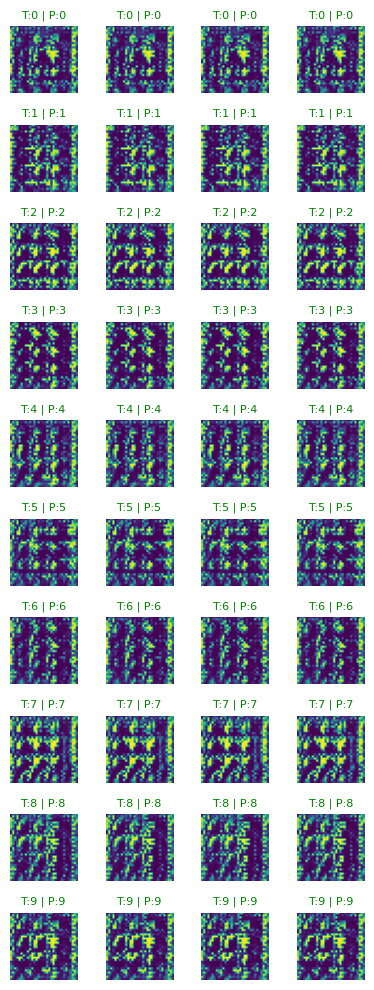

[GEN] Ep 11/100 | Loss 648.1188 | KL 2.1677 | CE 0.0359 | COS 0.2849 | ORT 0.1382 | SSIM 0.0011 | time 37.4s
[GEN] Ep 12/100 | Loss 645.7419 | KL 2.1628 | CE 0.0370 | COS 0.2833 | ORT 0.1376 | SSIM 0.0011 | time 37.4s
[GEN] Ep 13/100 | Loss 643.4182 | KL 2.1570 | CE 0.0364 | COS 0.2821 | ORT 0.1373 | SSIM 0.0011 | time 37.5s
[GEN] Ep 14/100 | Loss 642.5128 | KL 2.1610 | CE 0.0355 | COS 0.2813 | ORT 0.1370 | SSIM 0.0011 | time 37.4s
[GEN] Ep 15/100 | Loss 639.6097 | KL 2.1578 | CE 0.0339 | COS 0.2798 | ORT 0.1362 | SSIM 0.0010 | time 37.3s
[GEN] Ep 16/100 | Loss 638.6460 | KL 2.1540 | CE 0.0340 | COS 0.2794 | ORT 0.1360 | SSIM 0.0010 | time 37.3s
[GEN] Ep 17/100 | Loss 636.8262 | KL 2.1508 | CE 0.0342 | COS 0.2785 | ORT 0.1354 | SSIM 0.0010 | time 37.2s
[GEN] Ep 18/100 | Loss 637.4582 | KL 2.1496 | CE 0.0356 | COS 0.2785 | ORT 0.1359 | SSIM 0.0010 | time 37.3s
[GEN] Ep 19/100 | Loss 635.3026 | KL 2.1451 | CE 0.0345 | COS 0.2775 | ORT 0.1354 | SSIM 0.0010 | time 37.3s
[GEN] Ep 20/100 | L

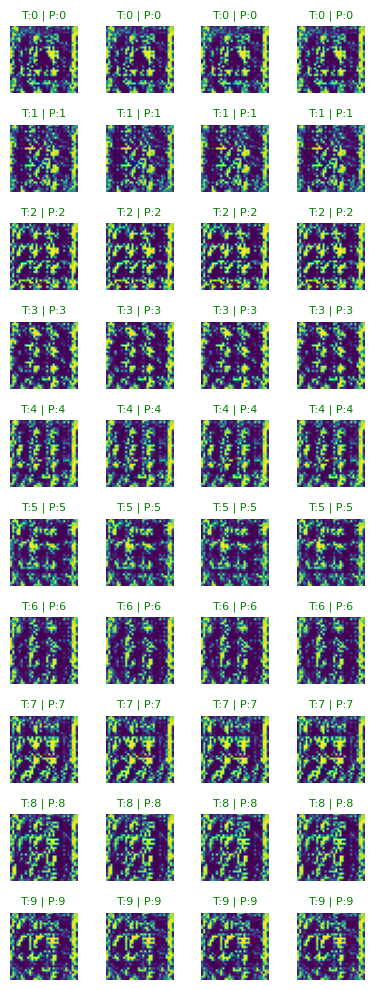

[GEN] Ep 21/100 | Loss 633.2819 | KL 2.1398 | CE 0.0351 | COS 0.2765 | ORT 0.1348 | SSIM 0.0010 | time 37.5s
[GEN] Ep 22/100 | Loss 633.8276 | KL 2.1436 | CE 0.0349 | COS 0.2765 | ORT 0.1350 | SSIM 0.0010 | time 37.5s
[GEN] Ep 23/100 | Loss 631.0554 | KL 2.1427 | CE 0.0329 | COS 0.2752 | ORT 0.1340 | SSIM 0.0009 | time 37.5s
[GEN] Ep 24/100 | Loss 630.9931 | KL 2.1387 | CE 0.0349 | COS 0.2753 | ORT 0.1339 | SSIM 0.0009 | time 37.4s
[GEN] Ep 25/100 | Loss 629.5538 | KL 2.1370 | CE 0.0316 | COS 0.2748 | ORT 0.1338 | SSIM 0.0009 | time 37.4s
[GEN] Ep 26/100 | Loss 629.4132 | KL 2.1331 | CE 0.0320 | COS 0.2747 | ORT 0.1341 | SSIM 0.0009 | time 37.3s
[GEN] Ep 27/100 | Loss 629.6389 | KL 2.1378 | CE 0.0319 | COS 0.2747 | ORT 0.1339 | SSIM 0.0009 | time 37.2s
[GEN] Ep 28/100 | Loss 630.2633 | KL 2.1375 | CE 0.0319 | COS 0.2750 | ORT 0.1342 | SSIM 0.0009 | time 37.2s
[GEN] Ep 29/100 | Loss 629.8266 | KL 2.1335 | CE 0.0330 | COS 0.2748 | ORT 0.1342 | SSIM 0.0009 | time 37.2s
[GEN] Ep 30/100 | L

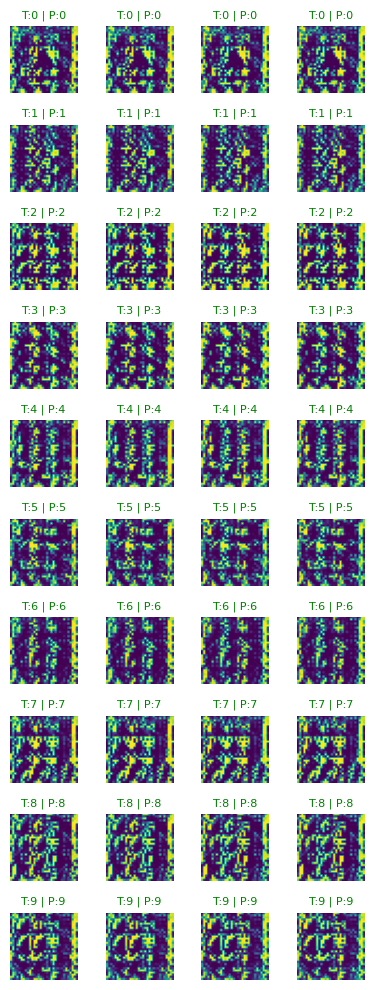

[GEN] Ep 31/100 | Loss 627.4351 | KL 2.1316 | CE 0.0318 | COS 0.2737 | ORT 0.1333 | SSIM 0.0009 | time 37.3s
[GEN] Ep 32/100 | Loss 628.9743 | KL 2.1279 | CE 0.0322 | COS 0.2746 | ORT 0.1343 | SSIM 0.0009 | time 37.3s
[GEN] Ep 33/100 | Loss 628.3566 | KL 2.1266 | CE 0.0322 | COS 0.2744 | ORT 0.1340 | SSIM 0.0009 | time 37.4s
[GEN] Ep 34/100 | Loss 628.2754 | KL 2.1228 | CE 0.0335 | COS 0.2743 | ORT 0.1341 | SSIM 0.0009 | time 37.4s
[GEN] Ep 35/100 | Loss 627.6796 | KL 2.1268 | CE 0.0323 | COS 0.2739 | ORT 0.1338 | SSIM 0.0009 | time 37.3s
[GEN] Ep 36/100 | Loss 626.3547 | KL 2.1225 | CE 0.0317 | COS 0.2735 | ORT 0.1334 | SSIM 0.0009 | time 37.2s
[GEN] Ep 37/100 | Loss 625.5227 | KL 2.1203 | CE 0.0322 | COS 0.2731 | ORT 0.1331 | SSIM 0.0009 | time 37.2s
[GEN] Ep 38/100 | Loss 626.4277 | KL 2.1153 | CE 0.0316 | COS 0.2739 | ORT 0.1338 | SSIM 0.0009 | time 37.2s
[GEN] Ep 39/100 | Loss 624.9549 | KL 2.1197 | CE 0.0323 | COS 0.2728 | ORT 0.1328 | SSIM 0.0009 | time 37.2s
[GEN] Ep 40/100 | L

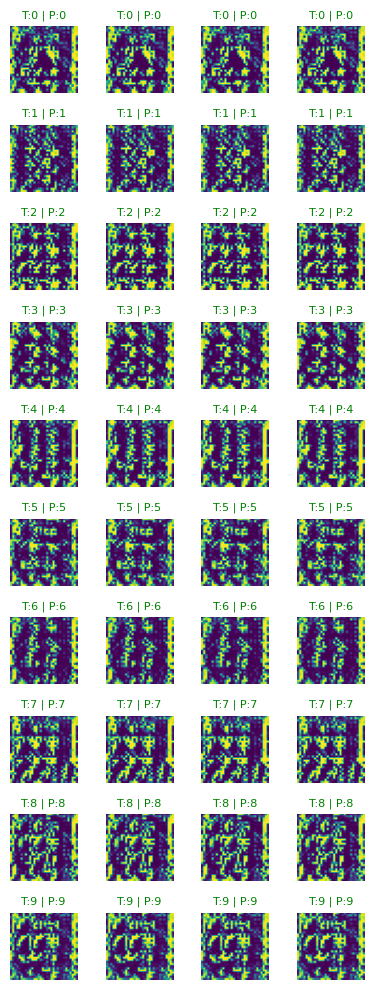

[GEN] Ep 41/100 | Loss 624.8561 | KL 2.1119 | CE 0.0331 | COS 0.2730 | ORT 0.1332 | SSIM 0.0009 | time 37.3s
[GEN] Ep 42/100 | Loss 625.7177 | KL 2.1156 | CE 0.0322 | COS 0.2733 | ORT 0.1335 | SSIM 0.0009 | time 37.4s
[GEN] Ep 43/100 | Loss 625.9614 | KL 2.1167 | CE 0.0324 | COS 0.2733 | ORT 0.1336 | SSIM 0.0009 | time 37.3s
[GEN] Ep 44/100 | Loss 623.8853 | KL 2.1114 | CE 0.0322 | COS 0.2726 | ORT 0.1329 | SSIM 0.0009 | time 37.2s
[GEN] Ep 45/100 | Loss 623.8105 | KL 2.1084 | CE 0.0329 | COS 0.2725 | ORT 0.1330 | SSIM 0.0009 | time 37.2s
[GEN] Ep 46/100 | Loss 624.3801 | KL 2.1087 | CE 0.0328 | COS 0.2728 | ORT 0.1333 | SSIM 0.0009 | time 37.2s
[GEN] Ep 47/100 | Loss 624.1587 | KL 2.1062 | CE 0.0329 | COS 0.2728 | ORT 0.1333 | SSIM 0.0009 | time 37.2s
[GEN] Ep 48/100 | Loss 622.4839 | KL 2.1128 | CE 0.0314 | COS 0.2719 | ORT 0.1322 | SSIM 0.0009 | time 37.2s
[GEN] Ep 49/100 | Loss 623.9937 | KL 2.1013 | CE 0.0332 | COS 0.2728 | ORT 0.1335 | SSIM 0.0009 | time 37.2s
[GEN] Ep 50/100 | L

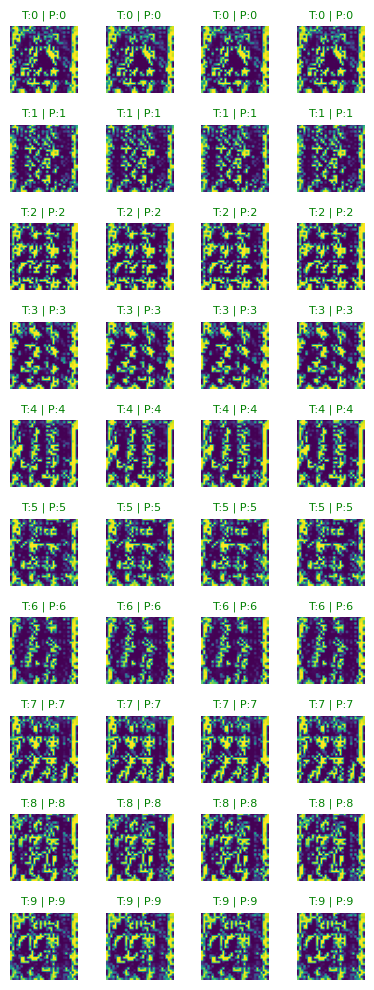

[GEN] Ep 51/100 | Loss 623.0994 | KL 2.1014 | CE 0.0319 | COS 0.2726 | ORT 0.1332 | SSIM 0.0008 | time 37.5s
[GEN] Ep 52/100 | Loss 622.7117 | KL 2.1010 | CE 0.0312 | COS 0.2726 | ORT 0.1330 | SSIM 0.0009 | time 37.4s
[GEN] Ep 53/100 | Loss 622.7870 | KL 2.0978 | CE 0.0330 | COS 0.2724 | ORT 0.1332 | SSIM 0.0008 | time 37.5s
[GEN] Ep 54/100 | Loss 623.4336 | KL 2.1012 | CE 0.0327 | COS 0.2726 | ORT 0.1333 | SSIM 0.0008 | time 37.4s
[GEN] Ep 55/100 | Loss 621.7866 | KL 2.0987 | CE 0.0321 | COS 0.2720 | ORT 0.1327 | SSIM 0.0008 | time 37.3s
[GEN] Ep 56/100 | Loss 623.4859 | KL 2.0960 | CE 0.0329 | COS 0.2728 | ORT 0.1337 | SSIM 0.0008 | time 37.3s
[GEN] Ep 57/100 | Loss 621.7323 | KL 2.0974 | CE 0.0326 | COS 0.2720 | ORT 0.1327 | SSIM 0.0008 | time 37.3s
[GEN] Ep 58/100 | Loss 622.2653 | KL 2.0920 | CE 0.0335 | COS 0.2724 | ORT 0.1331 | SSIM 0.0008 | time 37.2s
[GEN] Ep 59/100 | Loss 621.7688 | KL 2.0942 | CE 0.0320 | COS 0.2721 | ORT 0.1330 | SSIM 0.0008 | time 37.2s
[GEN] Ep 60/100 | L

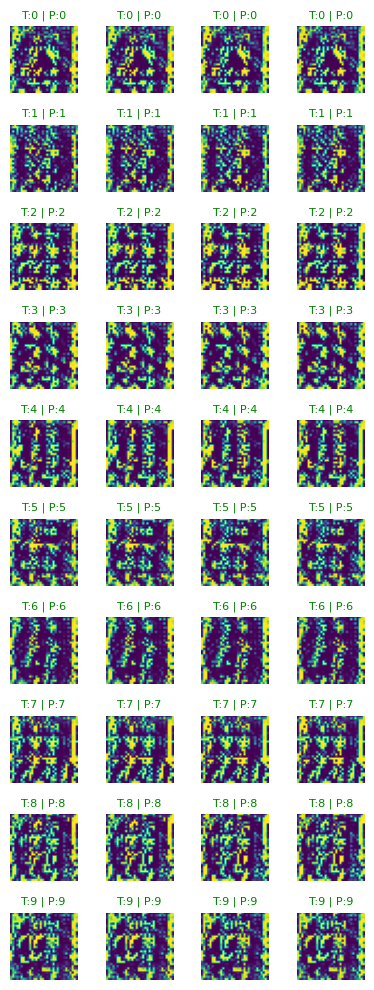

[GEN] Ep 61/100 | Loss 621.6143 | KL 2.0924 | CE 0.0330 | COS 0.2721 | ORT 0.1328 | SSIM 0.0008 | time 37.3s
[GEN] Ep 62/100 | Loss 620.8971 | KL 2.0880 | CE 0.0329 | COS 0.2719 | ORT 0.1328 | SSIM 0.0008 | time 37.5s
[GEN] Ep 63/100 | Loss 621.2916 | KL 2.0884 | CE 0.0329 | COS 0.2721 | ORT 0.1329 | SSIM 0.0008 | time 37.3s
[GEN] Ep 64/100 | Loss 620.8793 | KL 2.0891 | CE 0.0323 | COS 0.2719 | ORT 0.1328 | SSIM 0.0008 | time 37.3s
[GEN] Ep 65/100 | Loss 621.8530 | KL 2.0893 | CE 0.0330 | COS 0.2723 | ORT 0.1332 | SSIM 0.0008 | time 37.3s
[GEN] Ep 66/100 | Loss 621.5032 | KL 2.0839 | CE 0.0342 | COS 0.2723 | ORT 0.1331 | SSIM 0.0008 | time 37.2s
[GEN] Ep 67/100 | Loss 620.5400 | KL 2.0837 | CE 0.0324 | COS 0.2720 | ORT 0.1328 | SSIM 0.0008 | time 37.2s
[GEN] Ep 68/100 | Loss 621.1797 | KL 2.0858 | CE 0.0338 | COS 0.2720 | ORT 0.1330 | SSIM 0.0008 | time 37.3s
[GEN] Ep 69/100 | Loss 620.2241 | KL 2.0805 | CE 0.0341 | COS 0.2718 | ORT 0.1327 | SSIM 0.0008 | time 37.3s
[GEN] Ep 70/100 | L

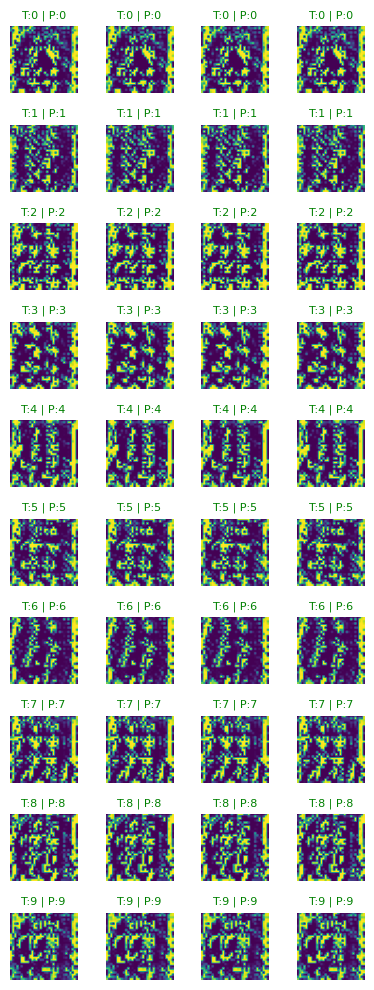

[GEN] Ep 71/100 | Loss 620.6656 | KL 2.0842 | CE 0.0343 | COS 0.2718 | ORT 0.1327 | SSIM 0.0008 | time 37.4s
[GEN] Ep 72/100 | Loss 620.8647 | KL 2.0814 | CE 0.0336 | COS 0.2721 | ORT 0.1330 | SSIM 0.0008 | time 37.4s
[GEN] Ep 73/100 | Loss 620.3837 | KL 2.0804 | CE 0.0326 | COS 0.2721 | ORT 0.1329 | SSIM 0.0008 | time 37.3s
[GEN] Ep 74/100 | Loss 619.0240 | KL 2.0816 | CE 0.0333 | COS 0.2712 | ORT 0.1322 | SSIM 0.0008 | time 37.1s
[GEN] Ep 75/100 | Loss 620.2303 | KL 2.0797 | CE 0.0334 | COS 0.2719 | ORT 0.1329 | SSIM 0.0008 | time 37.2s
[GEN] Ep 76/100 | Loss 620.0575 | KL 2.0766 | CE 0.0334 | COS 0.2720 | ORT 0.1329 | SSIM 0.0008 | time 37.3s
[GEN] Ep 77/100 | Loss 619.7831 | KL 2.0793 | CE 0.0330 | COS 0.2718 | ORT 0.1327 | SSIM 0.0008 | time 37.4s
[GEN] Ep 78/100 | Loss 618.9383 | KL 2.0758 | CE 0.0320 | COS 0.2716 | ORT 0.1326 | SSIM 0.0008 | time 37.4s
[GEN] Ep 79/100 | Loss 619.8745 | KL 2.0766 | CE 0.0334 | COS 0.2720 | ORT 0.1327 | SSIM 0.0008 | time 37.4s
[GEN] Ep 80/100 | L

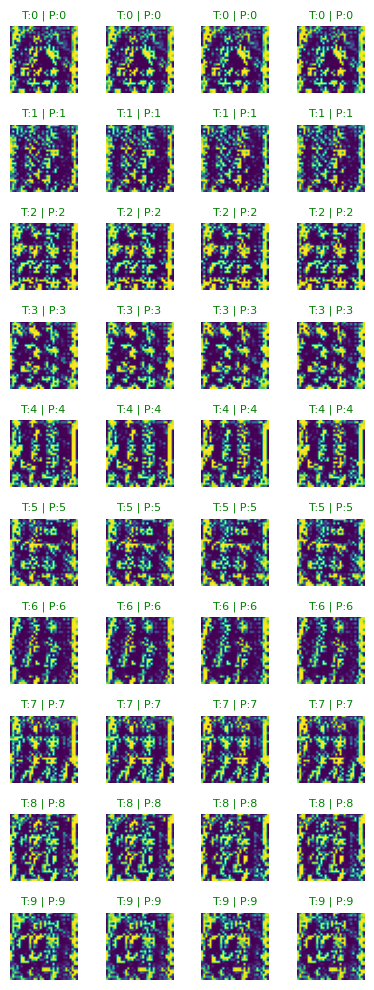

[GEN] Ep 81/100 | Loss 619.6847 | KL 2.0814 | CE 0.0331 | COS 0.2716 | ORT 0.1325 | SSIM 0.0008 | time 37.4s
[GEN] Ep 82/100 | Loss 619.6094 | KL 2.0766 | CE 0.0330 | COS 0.2717 | ORT 0.1328 | SSIM 0.0008 | time 37.4s
[GEN] Ep 83/100 | Loss 618.8881 | KL 2.0746 | CE 0.0328 | COS 0.2715 | ORT 0.1325 | SSIM 0.0008 | time 37.4s
[GEN] Ep 84/100 | Loss 619.8155 | KL 2.0716 | CE 0.0335 | COS 0.2721 | ORT 0.1331 | SSIM 0.0008 | time 37.4s
[GEN] Ep 85/100 | Loss 619.5036 | KL 2.0729 | CE 0.0336 | COS 0.2718 | ORT 0.1329 | SSIM 0.0008 | time 37.4s
[GEN] Ep 86/100 | Loss 619.4097 | KL 2.0725 | CE 0.0338 | COS 0.2718 | ORT 0.1328 | SSIM 0.0008 | time 37.4s
[GEN] Ep 87/100 | Loss 619.8138 | KL 2.0727 | CE 0.0331 | COS 0.2721 | ORT 0.1330 | SSIM 0.0008 | time 37.5s
[GEN] Ep 88/100 | Loss 619.0044 | KL 2.0667 | CE 0.0343 | COS 0.2718 | ORT 0.1328 | SSIM 0.0008 | time 37.5s
[GEN] Ep 89/100 | Loss 619.0845 | KL 2.0689 | CE 0.0340 | COS 0.2717 | ORT 0.1328 | SSIM 0.0008 | time 37.4s
[GEN] Ep 90/100 | L

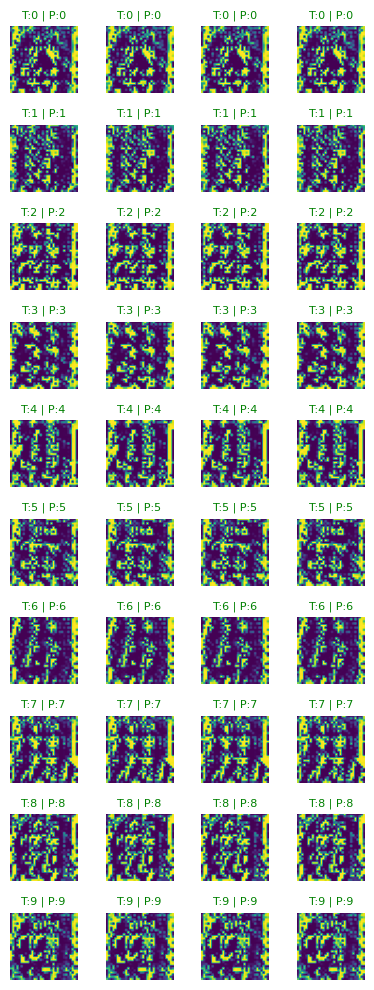

[GEN] Ep 91/100 | Loss 618.4154 | KL 2.0719 | CE 0.0336 | COS 0.2712 | ORT 0.1325 | SSIM 0.0008 | time 37.5s
[GEN] Ep 92/100 | Loss 619.5246 | KL 2.0695 | CE 0.0336 | COS 0.2721 | ORT 0.1330 | SSIM 0.0008 | time 37.6s
[GEN] Ep 93/100 | Loss 617.8820 | KL 2.0669 | CE 0.0334 | COS 0.2713 | ORT 0.1324 | SSIM 0.0008 | time 37.5s
[GEN] Ep 94/100 | Loss 617.4060 | KL 2.0693 | CE 0.0345 | COS 0.2708 | ORT 0.1319 | SSIM 0.0008 | time 37.5s
[GEN] Ep 95/100 | Loss 618.4019 | KL 2.0695 | CE 0.0332 | COS 0.2715 | ORT 0.1326 | SSIM 0.0008 | time 37.4s
[GEN] Ep 96/100 | Loss 618.8776 | KL 2.0726 | CE 0.0341 | COS 0.2714 | ORT 0.1326 | SSIM 0.0008 | time 37.5s
[GEN] Ep 97/100 | Loss 618.9170 | KL 2.0647 | CE 0.0337 | COS 0.2718 | ORT 0.1331 | SSIM 0.0008 | time 37.5s
[GEN] Ep 98/100 | Loss 617.1803 | KL 2.0637 | CE 0.0327 | COS 0.2711 | ORT 0.1324 | SSIM 0.0008 | time 37.5s
[GEN] Ep 99/100 | Loss 617.8338 | KL 2.0667 | CE 0.0332 | COS 0.2712 | ORT 0.1325 | SSIM 0.0008 | time 37.4s
[GEN] Ep 100/100 | 

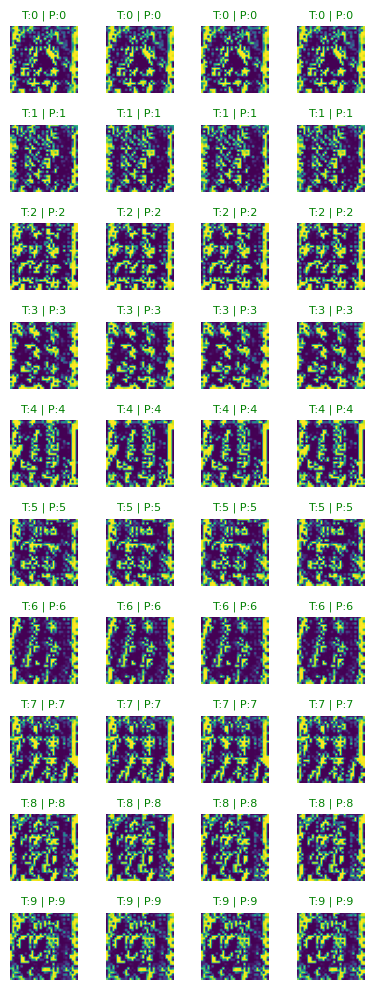

In [13]:
print("Starting generator training...")
train_generator(epochs=100, batch_size=64)



Running t-SNE evaluation...
[t-SNE] Inversion Accuracy: 60.50%


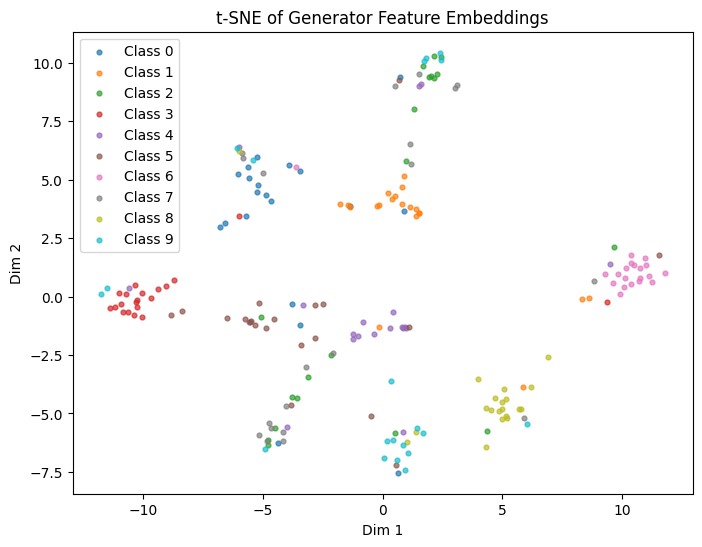

In [14]:
# Final t-SNE visualization
print("Running t-SNE evaluation...")
eval_tsne_grid(gen, classifier, samples_per_class=SAMPLES_PER_CLASS)

Generating final image grid...


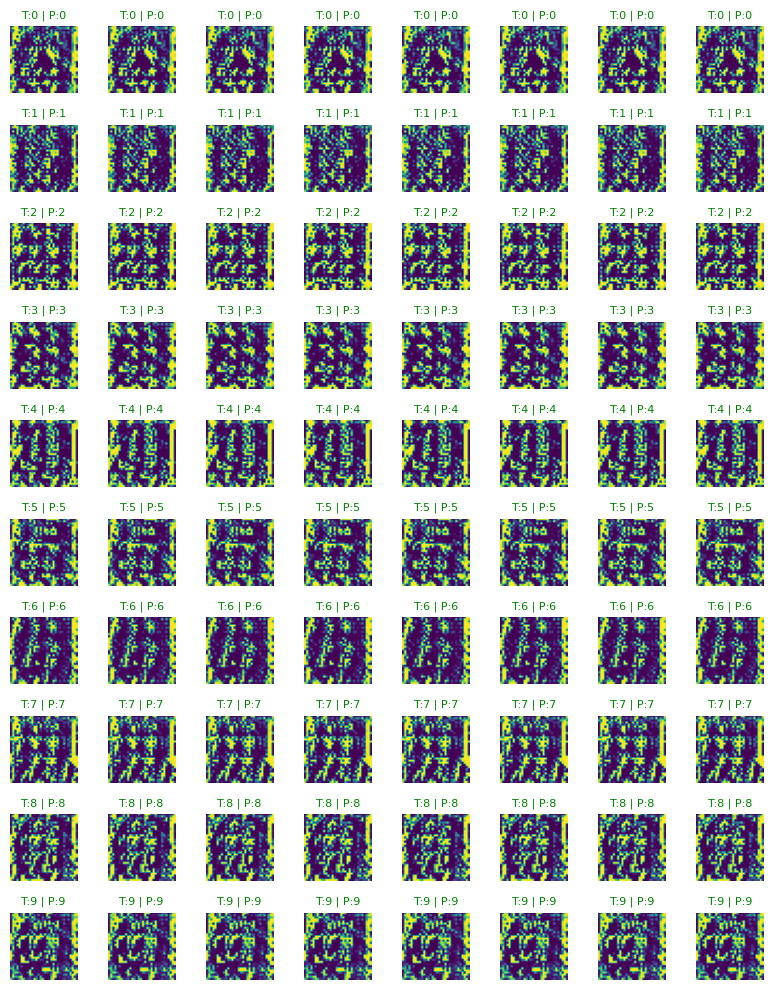

In [15]:
# Final grid of generated images
print("Generating final image grid...")
show_generated_images(gen, classifier, samples_per_class=8)

In [16]:
final_acc = inversion_accuracy(gen, classifier, n_per_class=100)
print(f"FINAL INVERSION ACCURACY: {final_acc:.2f}%")

FINAL INVERSION ACCURACY: 100.00%
